In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

In [ ]:
pd.

In [2]:
data = pd.read_csv('./merged/model_organism_v2.final_with_metrics.csv')
def filter_error_rows(df: pd.DataFrame, focus_col: str) -> pd.DataFrame:
    mask = df[focus_col].astype(str).str.contains(r"<error:", case=False, na=False)
    cleaned = df.loc[~mask].copy()
    return cleaned
data = filter_error_rows(data, focus_col="SynCodonLM_predicted_seq")

In [3]:
data.columns

Index(['organism', 'protein_seq', 'ground_truth_seq',
       'SynCodonLM_predicted_seq', 'CodonTransformer_predicted_seq',
       'CodonTranslator_predicted_seq', 'IDT_predicted_seq',
       'Twist_predicted_seq', 'Genewiz_predicted_seq', 'ICOR_predicted_seq',
       'HFC_predicted_seq', 'BFC_predicted_seq', 'URC_predicted_seq',
       'ground_truth_gc', 'ground_truth_ENC', 'ground_truth_CSI',
       'ground_truth_codon_similarity', 'ground_truth_minmax_mean',
       'ground_truth_minmax_dtw', 'SynCodonLM_gc', 'SynCodonLM_ENC',
       'SynCodonLM_CSI', 'SynCodonLM_codon_similarity',
       'SynCodonLM_minmax_mean', 'SynCodonLM_minmax_dtw',
       'CodonTransformer_gc', 'CodonTransformer_ENC', 'CodonTransformer_CSI',
       'CodonTransformer_codon_similarity', 'CodonTransformer_minmax_mean',
       'CodonTransformer_minmax_dtw', 'CodonTranslator_gc',
       'CodonTranslator_ENC', 'CodonTranslator_CSI',
       'CodonTranslator_codon_similarity', 'CodonTranslator_minmax_mean',
       'Cod

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
sns.set_context("paper")
# --- Method order + your palette ---
ORDER = ["CodonTranslator", "CodonTransformer", "SynCodonLM", "Twist", "IDT", "Genewiz"]
_base = sns.color_palette()
_colors = [_base[i] for i in [0, 1, 4, 3, 5, 6, 9]]
PALETTE = dict(zip(ORDER, _colors[:len(ORDER)]))

PREFERRED_ORG_ORDER = [
    "Escherichia coli", "Saccharomyces cerevisiae",
    "Arabidopsis thaliana", "Mus musculus", "Homo sapiens"
]
import matplotlib as mpl
import seaborn as sns

def setup_theme():
    # Clean background, no grid, then hard-override gray rcParams
    sns.set_style("white")
    mpl.rcParams.update({
        "axes.edgecolor": "black",   # force black frame
        "axes.linewidth": 0.25,      # thin frame
        "xtick.color": "black",
        "ytick.color": "black",
        "text.color": "black",
        "figure.facecolor": "white",
        "axes.facecolor": "white",
    })

def melt_metric(df, metric_suffix, methods=ORDER):
    chunks = []
    for m in methods:
        col = f"{m}_{metric_suffix}"
        if col in df.columns:
            t = df[["organism", col]].rename(columns={col: "value"}).copy()
            t["method"] = m
            chunks.append(t)
    out = pd.concat(chunks, ignore_index=True)
    out = out[pd.to_numeric(out["value"], errors="coerce").notna()].copy()
    out["value"] = out["value"].astype(float)
    out["method"] = out["method"].astype(CategoricalDtype(categories=methods, ordered=True))
    return out

def ordered_orgs(df_long):
    present = list(pd.unique(df_long["organism"]))
    ordered = [o for o in PREFERRED_ORG_ORDER if o in present]
    extras = sorted([o for o in present if o not in ordered])
    return ordered + extras

def style_axes(ax, *, is_left: bool, spine_lw: float = 0.25):
    # No grid lines/background
    ax.grid(False)
    # Show only bottom + (left on first col); make all spines black and 0.25 pt
    for side in ["top", "right"]:
        ax.spines[side].set_visible(False)
    if is_left:
        ax.spines["left"].set_visible(True)
    else:
        ax.spines["left"].set_visible(False)
        ax.tick_params(axis="y", left=False, labelleft=False)

    for side in ["bottom", "left", "top", "right"]:
        ax.spines[side].set_linewidth(spine_lw)
        ax.spines[side].set_edgecolor("black")
    ax.tick_params(axis="x", colors="black")
    ax.tick_params(axis="y", colors="black")

def multi_panel(df_long, title: str, ylabel: str, y_min=None, y_max=None):
    orgs = ordered_orgs(df_long)
    ncols, nrows = 5, 2
    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 8), sharey=True)
    axes = axes.ravel()
    sns.set_style("white")  # clean background

    # Thin line styles for the whole boxplot
    box_kws = dict(
        linewidth=0.25,
        boxprops=dict(linewidth=0.25, edgecolor="black"),
        whiskerprops=dict(linewidth=0.25, color="black"),
        capprops=dict(linewidth=0.25, color="black"),
        medianprops=dict(linewidth=0.25, color="black"),
        fliersize=0
    )

    for i, ax in enumerate(axes):
        if i < len(orgs):
            org = orgs[i]
            sub = df_long[df_long["organism"] == org]

            sns.boxplot(
                data=sub, x="method", y="value", order=ORDER,
                palette=PALETTE, ax=ax, **box_kws
            )
            # Keep points fully vector-safe for EPS (no transparency)
            sns.stripplot(
                data=sub, x="method", y="value", order=ORDER,
                palette=PALETTE, ax=ax, dodge=False, alpha=1.0, size=4, linewidth=0
            )

            if (y_min is not None) or (y_max is not None):
                lo, hi = ax.get_ylim()
                ax.set_ylim(bottom=y_min if y_min is not None else lo,
                            top=y_max if y_max is not None else hi)

            ax.set_title(org, fontsize=12, pad=6, color="black", fontstyle="italic")
            ax.set_xlabel("")
            if i % ncols == 0:
                ax.set_ylabel(ylabel, color="black")
                style_axes(ax, is_left=True, spine_lw=0.25)
            else:
                ax.set_ylabel("")
                style_axes(ax, is_left=False, spine_lw=0.25)
            ax.tick_params(axis="x", rotation=35)
        else:
            ax.axis("off")

    fig.suptitle(title, fontsize=16, y=0.98, color="black")
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    return fig

def plot_dtw_and_similarity(df: pd.DataFrame,
                            dtw_out: str = "dtw_panels.eps",
                            sim_out: str = "codon_similarity_panels.eps",
                            save: bool = True):
    # DTW (start at 0) — title simplified
    dtw_long = melt_metric(df, "minmax_dtw")
    fig_dtw = multi_panel(dtw_long, "DTW distance", "DTW distance", y_min=0)

    # Codon similarity in [0,1]
    sim_long = melt_metric(df, "codon_similarity")
    fig_sim = multi_panel(sim_long, "Codon similarity", "Similarity", y_min=0, y_max=1)

    if save:
        fig_dtw.savefig(dtw_out, format="eps", bbox_inches="tight")
        fig_sim.savefig(sim_out, format="eps", bbox_inches="tight")
    return fig_dtw, fig_sim

# Usage:
# fig_dtw, fig_sim = plot_dtw_and_similarity(df)
# plt.show()


/var/folders/3f/llq03h9s01b8gp_qjrrnx_l40000gn/T/ipykernel_63761/1808791004.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/3f/llq03h9s01b8gp_qjrrnx_l40000gn/T/ipykernel_63761/1808791004.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
/var/folders/3f/llq03h9s01b8gp_qjrrnx_l40000gn/T/ipykernel_63761/1808791004.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/3f/llq03h9s01b8gp_qjrrnx_l40000gn/T/ipykernel_63761/1808791004.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated

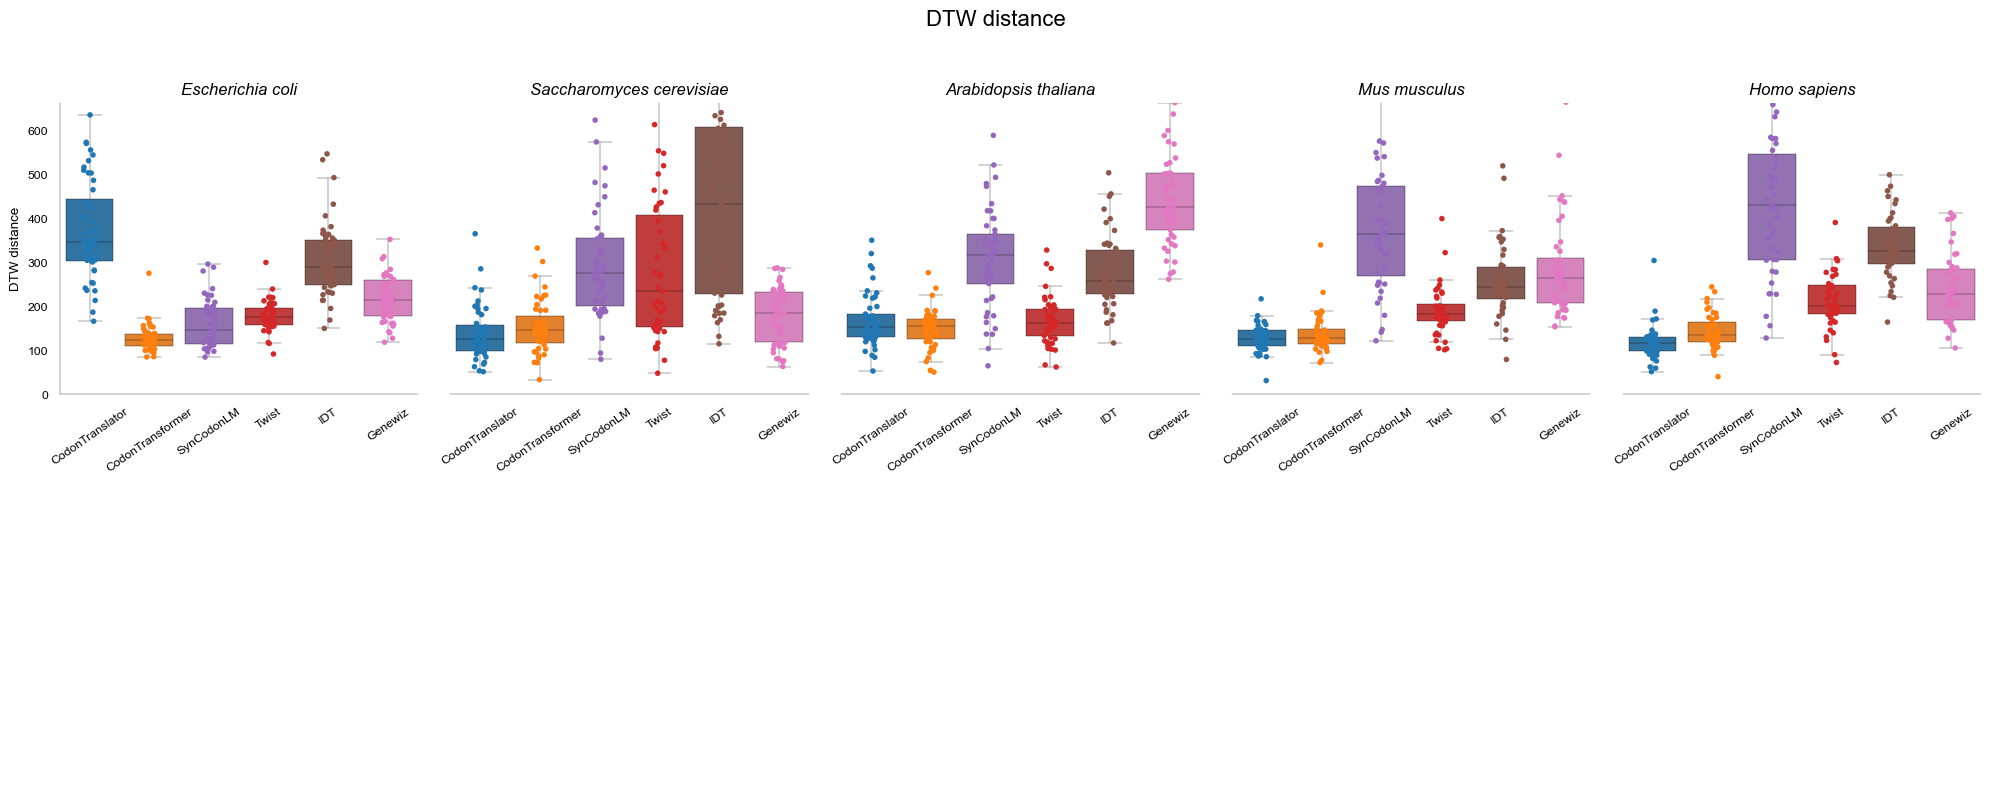

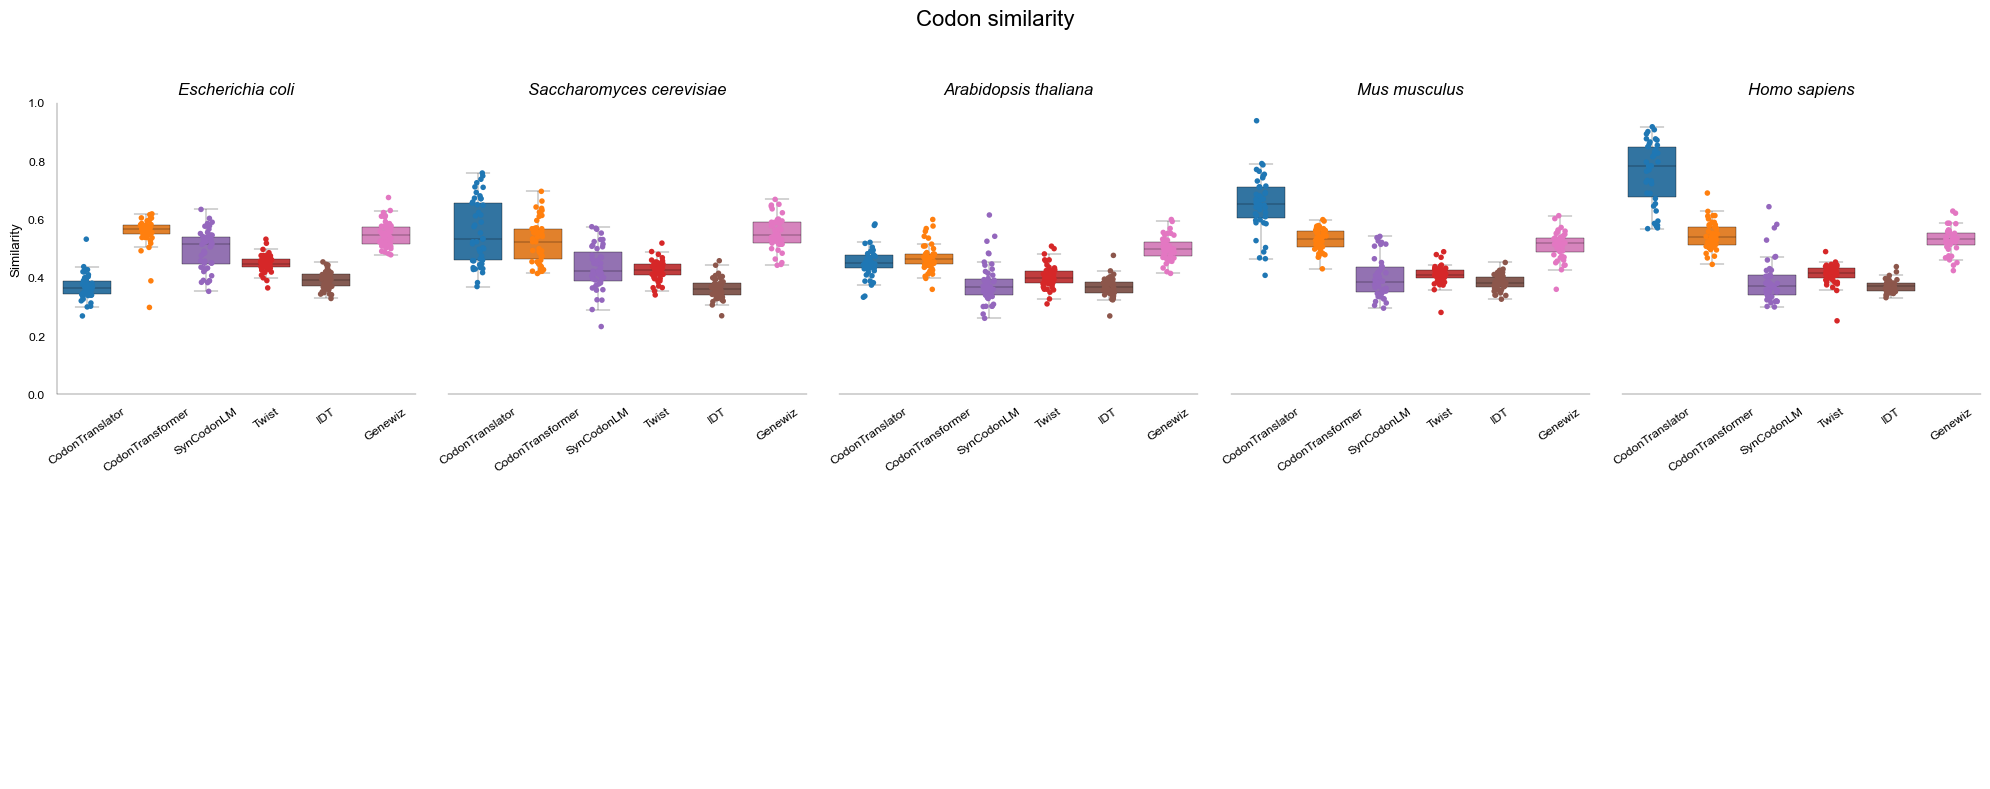

In [5]:
setup_theme()
fig_dtw, fig_sim = plot_dtw_and_similarity(data, save=True)

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.lines import Line2D
from pandas.api.types import CategoricalDtype

# -------------------- Style & palette --------------------
ORDER = ["CodonTranslator", "CodonTransformer", "SynCodonLM", "Twist", "IDT", "Genewiz"]  # note: 'SynCodonLM' spelling
_base = sns.color_palette()
_colors = [_base[i] for i in [0, 1, 4, 3, 5, 6, 9]]  # last is spare
PALETTE = dict(zip(ORDER, _colors[:len(ORDER)]))
PALETTE_WITH_GT = {**PALETTE, "Ground truth": _colors[-1]}
PREFERRED_ORG_ORDER = [
    "Escherichia coli", "Saccharomyces cerevisiae",
    "Arabidopsis thaliana", "Mus musculus", "Homo sapiens"
]

def setup_theme():
    sns.set_style("white")  # clean background (no grid)
    rcParams.update({
        "axes.edgecolor": "black",
        "axes.linewidth": 0.25,
        "xtick.color": "black",
        "ytick.color": "black",
        "text.color": "black",
        "figure.facecolor": "white",
        "axes.facecolor": "white",
    })

def style_axes(ax, *, is_left: bool, spine_lw: float = 0.25):
    ax.grid(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    if is_left:
        ax.spines["left"].set_visible(True)
    else:
        ax.spines["left"].set_visible(False)
        ax.tick_params(axis="y", left=False, labelleft=False)
    for side, spine in ax.spines.items():
        if spine.get_visible():
            spine.set_linewidth(spine_lw)
            spine.set_color("black")

def ordered_orgs(df_like: pd.DataFrame) -> list:
    present = list(pd.unique(df_like["organism"]))
    ordered = [o for o in PREFERRED_ORG_ORDER if o in present]
    extras = sorted([o for o in present if o not in ordered])
    return ordered + extras

# -------------------- Data helpers --------------------
def melt_metric_with_gt(df: pd.DataFrame, metric_suffix: str) -> pd.DataFrame:
    """Return long df with columns: organism, method, value (methods + Ground truth)."""
    parts = []
    # methods
    for m in ORDER:
        col = f"{m}_{metric_suffix}"
        if col in df.columns:
            t = df[["organism", col]].rename(columns={col: "value"}).copy()
            t["method"] = m
            parts.append(t)
    # ground truth
    gt_col = f"ground_truth_{metric_suffix}"
    if gt_col in df.columns:
        gt = df[["organism", gt_col]].rename(columns={gt_col: "value"}).copy()
        gt["method"] = "Ground truth"
        parts.append(gt)

    out = pd.concat(parts, ignore_index=True)
    out = out[pd.to_numeric(out["value"], errors="coerce").notna()].copy()
    out["value"] = out["value"].astype(float)
    out["method"] = out["method"].astype(
        CategoricalDtype(categories=["Ground truth"] + ORDER, ordered=True)
    )
    return out

def build_enc_gc_long(df: pd.DataFrame) -> pd.DataFrame:
    frames = []
    if {"ground_truth_gc", "ground_truth_ENC"}.issubset(df.columns):
        gt = (df[["organism", "ground_truth_gc", "ground_truth_ENC"]]
              .rename(columns={"ground_truth_gc": "gc", "ground_truth_ENC": "enc"}))
        gt["method"] = "Ground truth"
        frames.append(gt)
    for m in ORDER:
        gc_col, enc_col = f"{m}_gc", f"{m}_ENC"
        if gc_col in df.columns and enc_col in df.columns:
            t = df[["organism", gc_col, enc_col]].rename(columns={gc_col: "gc", enc_col: "enc"})
            t["method"] = m
            frames.append(t)
    out = pd.concat(frames, ignore_index=True)
    out = out[pd.to_numeric(out["gc"], errors="coerce").notna() & pd.to_numeric(out["enc"], errors="coerce").notna()]
    out["gc"]  = out["gc"].astype(float)
    out["enc"] = out["enc"].astype(float)
    return out

# -------------------- Figure S-CSI (with Ground truth) --------------------
def plot_csi_panels_with_gt(df: pd.DataFrame, out_eps: str | None = None):
    setup_theme()
    csi = melt_metric_with_gt(df, "CSI")
    orgs = ordered_orgs(csi)
    ncols, nrows = 5, 1
    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 4), sharey=True)
    axes = np.atleast_1d(axes)

    box_kws = dict(
        linewidth=0.25,
        boxprops=dict(linewidth=0.25, edgecolor="black"),
        whiskerprops=dict(linewidth=0.25, color="black"),
        capprops=dict(linewidth=0.25, color="black"),
        medianprops=dict(linewidth=0.25, color="black"),
        fliersize=0
    )

    for i, ax in enumerate(axes):
        if i >= len(orgs):
            ax.axis("off"); continue
        org = orgs[i]
        sub = csi[csi["organism"] == org]

        sns.boxplot(data=sub, x="method", y="value",
                    order=["Ground truth"] + ORDER,
                    palette=PALETTE_WITH_GT, ax=ax, **box_kws)
        sns.stripplot(data=sub, x="method", y="value",
                      order=["Ground truth"] + ORDER,
                      palette=PALETTE_WITH_GT, ax=ax,
                      dodge=False, alpha=1.0, size=3.5, linewidth=0)

        ax.set_ylim(0, 1)
        ax.set_title(org, fontstyle="italic", fontsize=11, pad=6, color="black")
        ax.set_xlabel("")
        if i % ncols == 0:
            ax.set_ylabel("CSI")
            style_axes(ax, is_left=True)
        else:
            ax.set_ylabel("")
            style_axes(ax, is_left=False)
        ax.tick_params(axis="x", rotation=35)

    fig.suptitle("CSI", fontsize=14, y=0.98)
    fig.tight_layout(rect=[0, 0, 1, 0.94])
    if out_eps:
        fig.savefig(out_eps, format="eps", bbox_inches="tight")
    return fig

# -------------------- Figure S-ENC×GC KDE (one method per row) --------------------
def plot_enc_gc_kde_rows(df: pd.DataFrame,
                         out_eps: str | None = None,
                         methods_rows: list[str] | None = None,
                         levels: int = 6):
    """
    Grid = (len(methods_rows) rows) × (num_organisms columns).
    Each panel overlays the row's method (colored) with Ground truth (black).
    """
    setup_theme()
    data = build_enc_gc_long(df)
    orgs = ordered_orgs(data)
    methods = methods_rows if methods_rows is not None else ORDER  # default: all 6 methods

    nrows, ncols = len(methods), len(orgs)
    # sensible height per row (~3.2)
    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 24), sharex=True, sharey=True)
    axes = np.atleast_2d(axes)

    # robust ENC limits (consistent across grid)
    enc_lo = float(np.nanquantile(data["enc"], 0.01))
    enc_hi = float(np.nanquantile(data["enc"], 0.99))
    enc_lo = min(15.0, enc_lo)
    enc_hi = max(65.0, enc_hi)

    for r, method in enumerate(methods):
        for c, org in enumerate(orgs):
            ax = axes[r, c]
            sm_m = data[(data["method"] == method) & (data["organism"] == org)]
            sm_g = data[(data["method"] == "Ground truth") & (data["organism"] == org)]

            # colored method
            if not sm_m.empty:
                sns.kdeplot(data=sm_m, x="gc", y="enc", ax=ax, levels=levels,
                            fill=False, bw_adjust=1.0, color=PALETTE[method],
                            linewidth=0.9)
            # black ground truth
            if not sm_g.empty:
                sns.kdeplot(data=sm_g, x="gc", y="enc", ax=ax, levels=levels,
                            fill=False, bw_adjust=1.0, color=_colors[-1],
                            linewidth=1.2)

            ax.set_xlim(0, 1)
            ax.set_ylim(enc_lo, enc_hi)

            # titles & labels
            ax.set_title(org, fontstyle="italic", fontsize=10, pad=4, color="black")
            if r == nrows - 1:
                ax.set_xlabel("GC")
            else:
                ax.set_xlabel("")
            if c == 0:
                ax.set_ylabel("ENC")
                style_axes(ax, is_left=True)
                # row label on the left margin
                ax.text(-0.18, 0.5, method, transform=ax.transAxes,
                        ha="right", va="center", rotation=90, fontsize=10, color="black")
            else:
                ax.set_ylabel("")
                style_axes(ax, is_left=False)

    fig.suptitle("ENC–GC density (method vs Ground truth)", fontsize=14, y=0.995)
    fig.tight_layout(rect=[0, 0, 1, 0.98])
    if out_eps:
        fig.savefig(out_eps, format="eps", bbox_inches="tight")
    return fig




/var/folders/3f/llq03h9s01b8gp_qjrrnx_l40000gn/T/ipykernel_63761/3159724833.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sub, x="method", y="value",
/var/folders/3f/llq03h9s01b8gp_qjrrnx_l40000gn/T/ipykernel_63761/3159724833.py:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=sub, x="method", y="value",
/var/folders/3f/llq03h9s01b8gp_qjrrnx_l40000gn/T/ipykernel_63761/3159724833.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sub, x="method", y="value",
/var/folders/3f/llq03h9s01b8gp_qjrrnx_l40000gn/T/ipykern

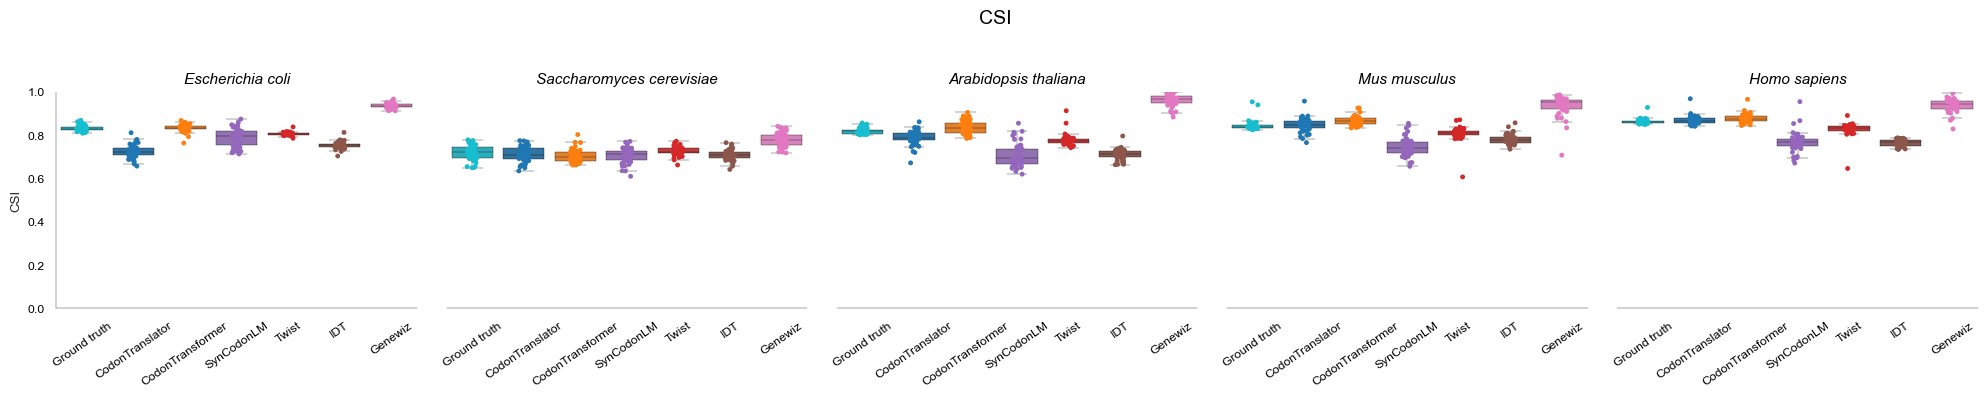

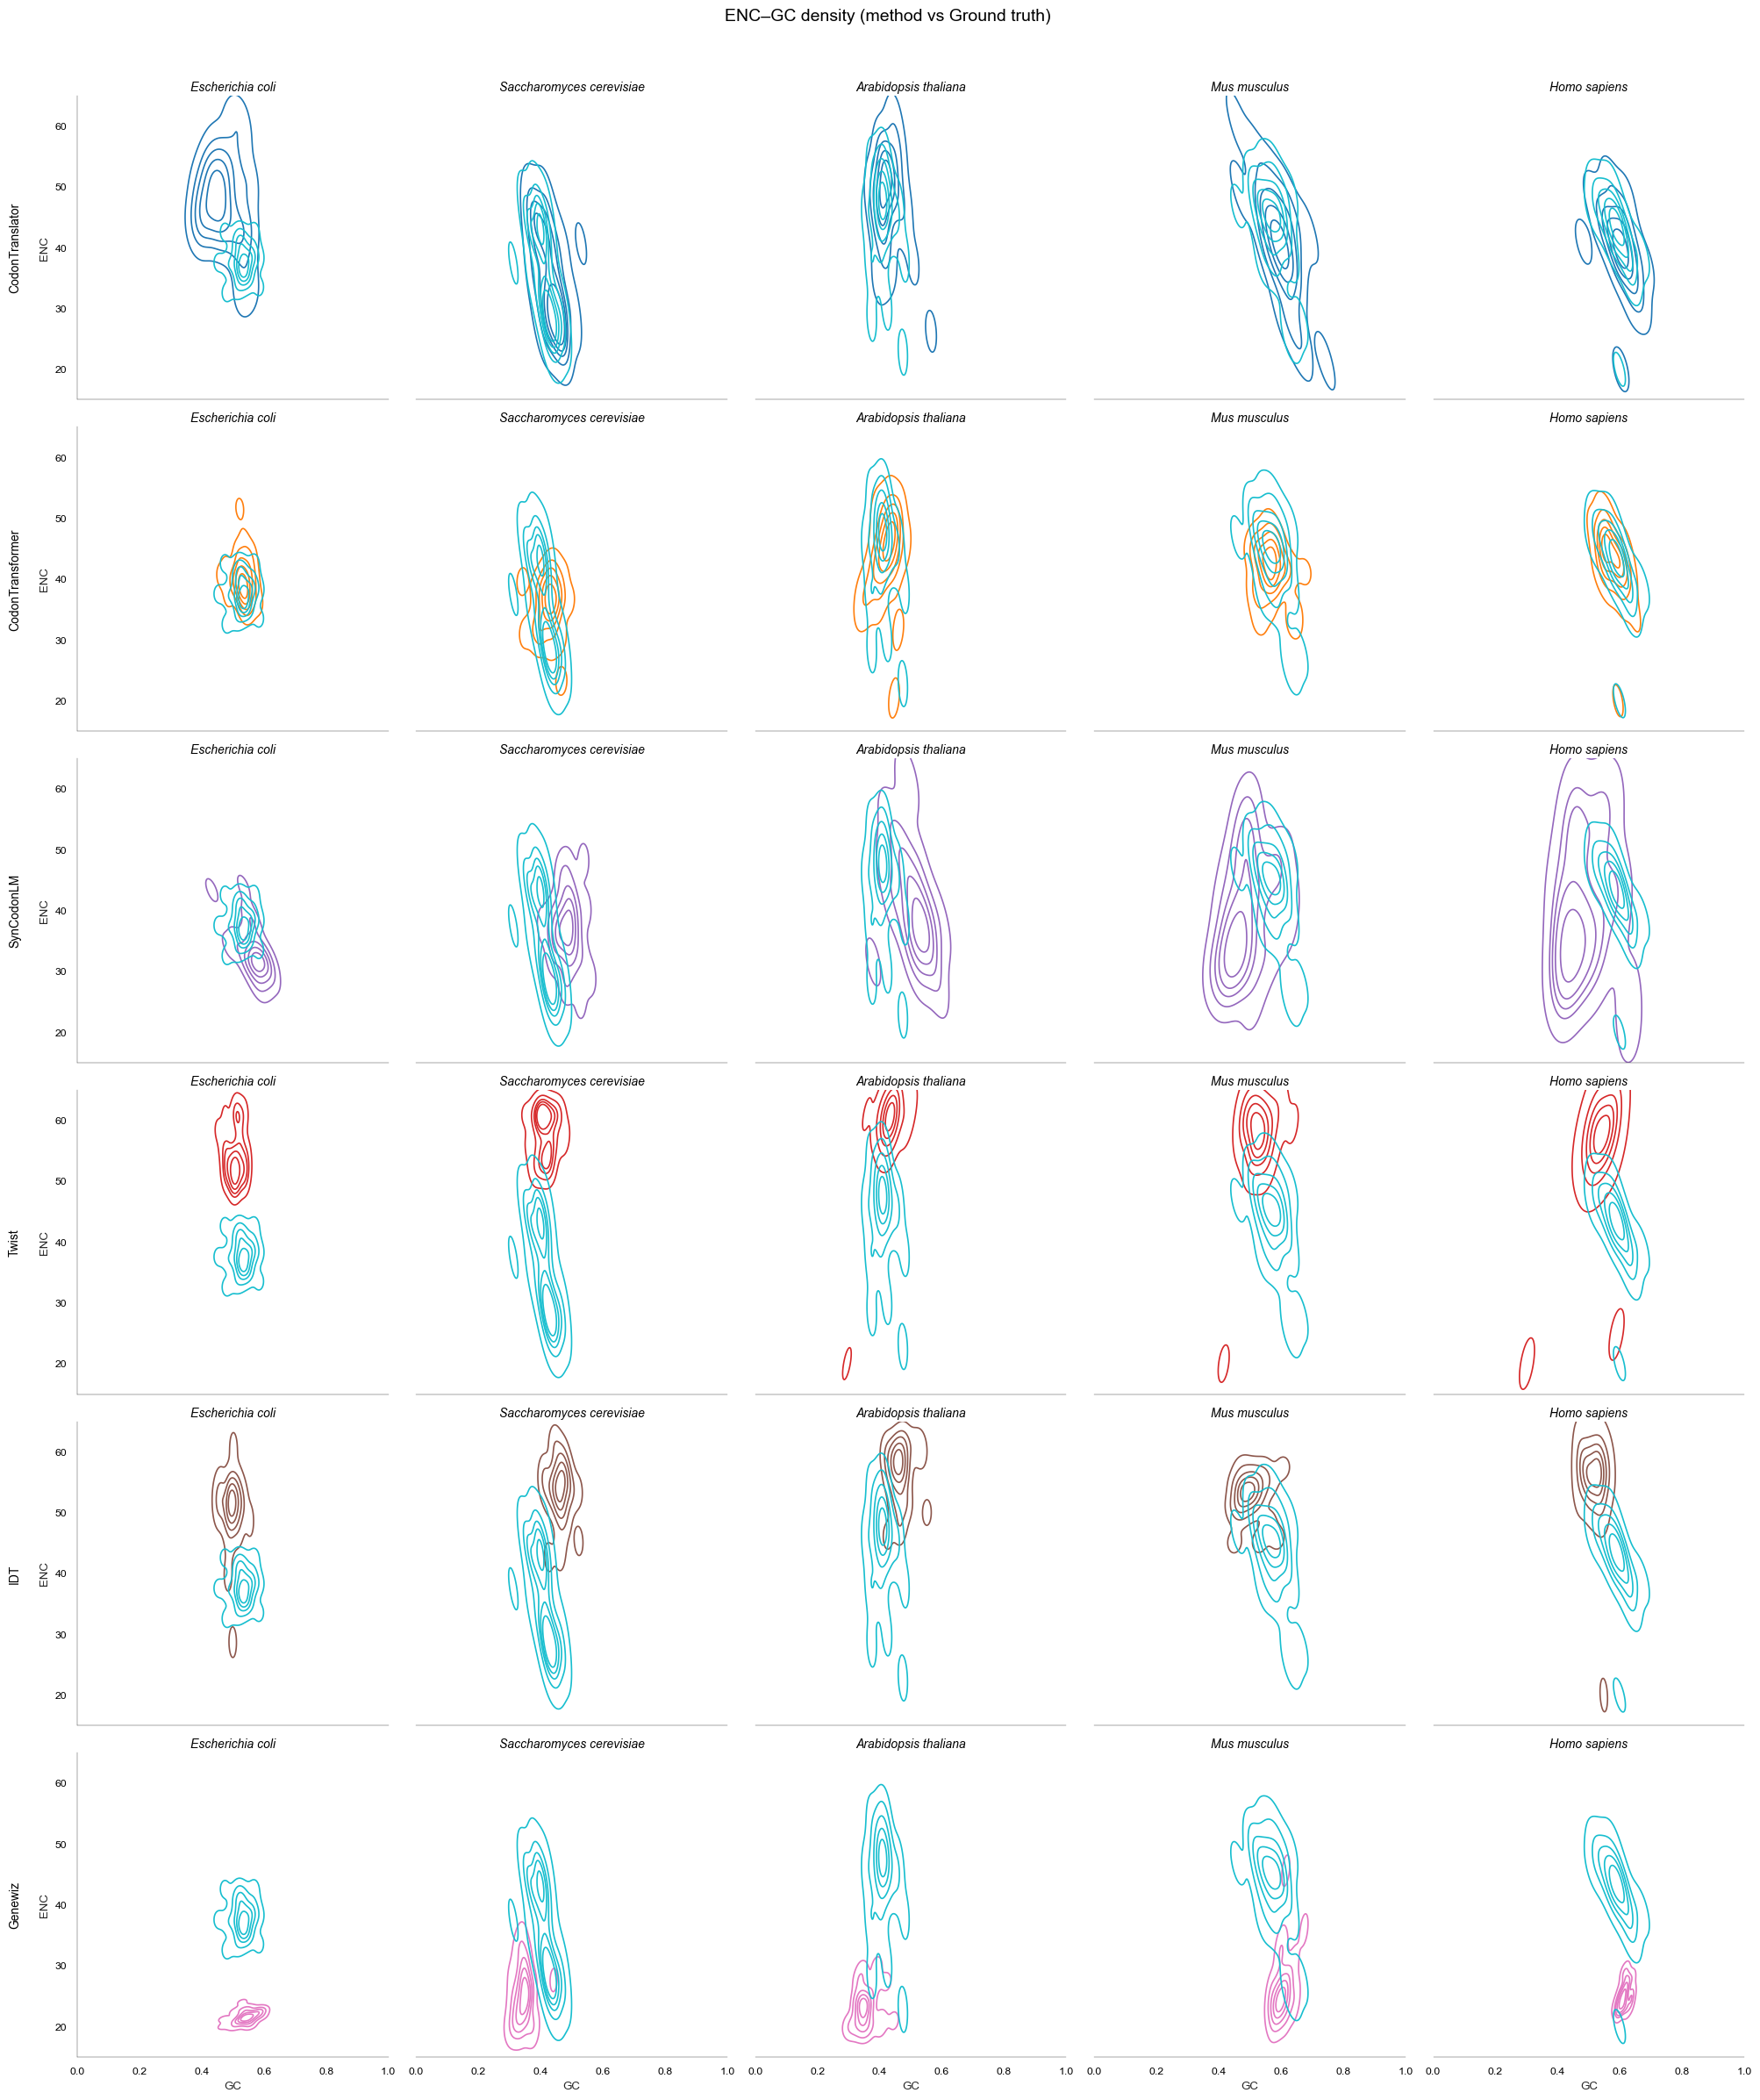

In [14]:
# -------------------- Usage --------------------
fig_csi = plot_csi_panels_with_gt(data, out_eps="supp_CSI_with_GT.eps")
fig_kde = plot_enc_gc_kde_rows(data, out_eps="supp_ENC_GC_KDE_rows.eps")
plt.show()